## 🧠 04e · Recommendation System Pattern with Ray Train 
In this notebook you build a **scalable matrix factorization recommendation system** using the **MovieLens 100K** dataset, fully distributed on an Anyscale cluster with **Ray Train V2** and **Ray Data**.

### What you’ll learn & take away  
* How to use **Ray Data** to load, encode, and shard tabular datasets across many workers  
* How to **stream training data** directly into PyTorch using `iter_torch_batches()`  
* How to build a **custom training loop with validation and checkpointing** using `ray.train.report()`  
* How to use **Ray Train V2's fault-tolerant trainer** to resume training from the latest checkpoint with no extra logic  
* How to separate **training, evaluation, and inference** while keeping all code modular and distributed-ready  
* How to run real-world recommendation workloads with **no changes to your model code**, thanks to Ray’s orchestration  


### 🔢 What problem are you solving? (Matrix factorization for recommendations)

You’re building a **collaborative filtering recommendation system** that predicts how much a user likes an item  
based on **historical interaction data** — in this case, user ratings from the MovieLens 100K dataset.

Use **matrix factorization**, a classic yet scalable approach where you embed each user and item in a latent space.  
The model learns to represent users and items as vectors and predicts ratings by computing their dot product.

---

### Input: User–Item–Rating triples

Each row in the dataset represents a user’s explicit rating of a movie:

$$
(u, {i}, r) \in \{\text{users}\} \times \{\text{items}\} \times \{1, 2, 3, 4, 5\}
$$

Encode these using contiguous integer indices (`user_idx`, `item_idx`)  
and normalize them for efficient embedding lookup and training.

---

### Model: Embedding-based matrix factorization

Learn an embedding vector for each user and each item:

$$
U_{u} \in \mathbb{R}^d, \quad V_{i} \in \mathbb{R}^d
$$

The predicted rating is the dot product of these vectors:

$$
\hat{r}_{u,{i}} = U_{u}^\top V_{i}
$$

The embedding dimension $d$ controls model capacity.

---

### Training objective

Minimize **Mean Squared Error (MSE)** between predicted and actual ratings:

$$
\mathcal{L} = \mathbb{E}_{(u, {i}, r)}\ \big(\hat{r}_{u,{i}} - r\big)^2
$$

This encourages the model to assign higher scores to user–item pairs that historically received high ratings.

---

### Inference: ranking items per user

Once trained, you can recommend items by computing predicted scores for a target user  
against **all items in the catalog**:

$$
\hat{r}_{u, *} = U_{u}^\top V^\top
$$

Sort these scores and return the top-N items as personalized recommendations.

---

### 🧭 How you’ll migrate this recommendation system workload to a distributed setup using Ray on Anyscale

This tutorial walks through how to **migrate a local matrix factorization pipeline for recommendation into a distributed, fault-tolerant training loop using Ray Train and Ray Data on Anyscale**.

Here’s how you approach the transition:

1. **Pandas DataFrame → Sharded Ray Dataset**  
   Load MovieLens 100K as a pandas DataFrame, encode the IDs, and use `ray.data.from_pandas_refs()` to create a **multi-block Ray Dataset**. Each block is a training shard that Ray can distribute across workers.

2. **Manual Batching → Streaming Torch Data loaders**  
   Instead of manually writing PyTorch `Dataset` logic, use `iter_torch_batches()` from **Ray Data** to stream batches directly into each worker. Ray handles all the parallelism and sharding behind the scenes.

3. **Single-node PyTorch → Multi-GPU Distributed Training**  
   Write a minimal `train_loop_per_worker` that runs on each Ray worker. Using `TorchTrainer` and `prepare_model()`, scale this loop across 8 GPU workers automatically, where each working on its own data shard.

4. **Ad-hoc Logging → Structured Epoch Logging and Checkpoints**  
   Each epoch logs `train_loss` and `val_loss` to a shared JSON file, and report checkpoints with `ray.train.report(checkpoint=...)`. This enables **automatic recovery and metric tracking** without any additional code.

5. **Resume and Scaling → Declarative Configuration**  
   Configure fault tolerance, checkpointing, and scaling using `ScalingConfig`, `CheckpointConfig`, and `FailureConfig`. This lets Ray + Anyscale handle retries, recovery, and GPU orchestration.

6. **Post-training Inference → Lightweight Python Function**  
   After training, load the latest checkpoint and generate top-N recommendations for any user with a simple forward pass. No retraining, no re-initialization, just pure PyTorch inference.

With just a few changes to your core code, scale a traditional recommendation pipeline across a Ray cluster with **distributed data loading, checkpointing, fault tolerance, and parallel training**, all fully managed by Anyscale.

### 01 · Imports  
Start by importing all the libraries you need for the rest of the notebook. These include standard utilities like `os`, `json`, and `pandas`, as well as deep learning libraries like PyTorch and visualization tools like `matplotlib`.

Also, import everything needed for **distributed training and data processing with Ray**:
- `ray` and `ray.data` provide the high-level distributed data API.
- `ray.train` gives you `TorchTrainer`, `ScalingConfig`, checkpointing, and metrics reporting.
- `prepare_model` wraps your PyTorch model for multi-worker training with Distributed Data Parallel (DDP).

A few extra helpers like `tqdm` and `train_test_split` round out the list for progress bars and quick offline preprocessing.

This notebook assumes Ray is already running (For example, with Anyscale), so you don’t call `ray.init()` manually.

In [1]:
# 00. Runtime setup — install same deps as build.sh and set env vars
import os, sys, subprocess

# Non-secret env var 
os.environ["RAY_TRAIN_V2_ENABLED"] = "1"

# Install Python dependencies 
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "--no-cache-dir",
    "torch==2.8.0",
    "matplotlib==3.10.6",
    "pyarrow==14.0.2",
])

0

In [2]:
# 01. Imports

# Standard libraries
import os
import uuid
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# Ray
import ray
import ray.data
from ray.train import ScalingConfig, RunConfig, CheckpointConfig, FailureConfig, Checkpoint, get_checkpoint, get_context,  get_dataset_shard, report
from ray.train.torch import TorchTrainer, prepare_model

# Other
from tqdm import tqdm

### 02 · Load MovieLens 100K Dataset  
Download and extract the [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/) dataset and persist a cleaned version to cluster storage under `/mnt/cluster_storage/rec_sys_tutorial/raw/ratings.csv`.

The MovieLens 100K dataset contains 100,000 ratings across 943 users and 1,682 movies. It’s small enough to train quickly, but realistic enough to demonstrate scaling and checkpointing with Ray Train.

If you already downloaded and extracted the dataset, skip both steps to save time. The output is a CSV with four columns: `user_id`, `item_id`, `rating`, and `timestamp`.

In [3]:
# 02. Load MovieLens 100K Dataset and store in /mnt/cluster_storage/

# Define clean working paths
DATA_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
LOCAL_ZIP = "/mnt/cluster_storage/rec_sys_tutorial/ml-100k.zip"
EXTRACT_DIR = "/mnt/cluster_storage/rec_sys_tutorial/ml-100k"
OUTPUT_CSV = "/mnt/cluster_storage/rec_sys_tutorial/raw/ratings.csv"

# Ensure target directories exist
os.makedirs("/mnt/cluster_storage/rec_sys_tutorial/raw", exist_ok=True)

# Download only if not already done
if not os.path.exists(LOCAL_ZIP):
    !wget -q $DATA_URL -O $LOCAL_ZIP

# Extract cleanly
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(LOCAL_ZIP, 'r') as zip_ref:
        zip_ref.extractall("/mnt/cluster_storage/rec_sys_tutorial")

# Load raw file
raw_path = os.path.join(EXTRACT_DIR, "u.data")
df = pd.read_csv(raw_path, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Save cleaned version
df.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Loaded {len(df):,} ratings → {OUTPUT_CSV}")
df.head()

✅ Loaded 100,000 ratings → /mnt/cluster_storage/rec_sys_tutorial/raw/ratings.csv


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### 03 · Preprocess IDs and Create Ray Dataset  
Begin preprocessing by encoding `user_id` and `item_id` into contiguous integer indices required for embedding layers. These encoded columns—`user_idx` and `item_idx`—are what your model uses during training.

After encoding, drop the original IDs and split the dataset into 64 chunks. Serialize each chunk and push to Ray’s object store using `ray.put(...)`. This allows Ray Data to construct a distributed dataset in the next step without creating a bottleneck on a single worker or process.

In [4]:
# 03. Preprocess IDs and create Ray Dataset in parallel

# Load CSV
df = pd.read_csv("/mnt/cluster_storage/rec_sys_tutorial/raw/ratings.csv")

# Encode user_id and item_id
user2idx = {uid: j for j, uid in enumerate(sorted(df["user_id"].unique()))}
item2idx = {iid: j for j, iid in enumerate(sorted(df["item_id"].unique()))}

df["user_idx"] = df["user_id"].map(user2idx)
df["item_idx"] = df["item_id"].map(item2idx)
df = df[["user_idx", "item_idx", "rating", "timestamp"]]

# Split into multiple chunks for parallel ingestion
NUM_SPLITS = 64  # adjust based on cluster size
dfs = np.array_split(df, NUM_SPLITS)
object_refs = [ray.put(split) for split in dfs]

/home/ray/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
2025-09-29 09:19:00,222	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 10.0.82.26:6379...
2025-09-29 09:19:00,234	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-qeldn6zjudjryzt3wypjak8arr.i.anyscaleuserdata.com 
2025-09-29 09:19:00,236	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_9805caaa8621aee12da64046057b6e8898f77509.zip' (0.06MiB) to Ray cluster...
2025-09-29 09:19:00,237	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_9805caaa8621aee12da64046057b6e8898f77509.zip'.


### 04 · Visualize Dataset: Ratings, Users, and Items  
Before training, visualize the distribution of ratings, user activity, and item popularity. These quick checks help you verify that the dataset parses correctly and reveal useful patterns:

- The first plot shows the overall rating distribution (1–5 stars). As expected, you see a skew toward 4 and 5.
- The second plot shows how many ratings each user has submitted. There’s a long tail: a few power users, but many light users.
- The third plot shows how often users rated each item. Again, you see a long-tail distribution common in recommendation settings.

These histograms give you a sense of sparsity and coverage, both of which influence model performance.

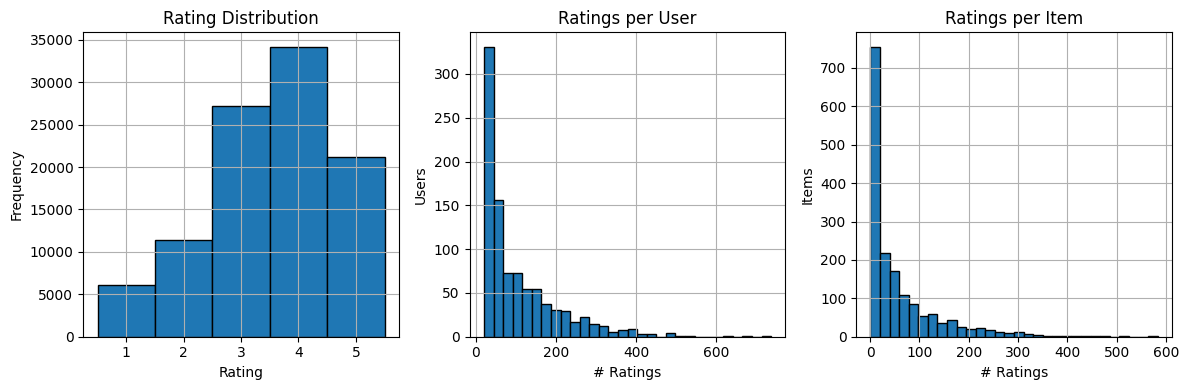

In [5]:
# 04. Visualize Dataset: Ratings, User & Item Activity

# Plot rating distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df["rating"].hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], edgecolor='black')
plt.title("Rating Distribution")
plt.xlabel("Rating"); plt.ylabel("Frequency")

# Plot number of ratings per user
plt.subplot(1, 3, 2)
df["user_idx"].value_counts().hist(bins=30, edgecolor='black')
plt.title("Ratings per User")
plt.xlabel("# Ratings"); plt.ylabel("Users")

# Plot number of ratings per item
plt.subplot(1, 3, 3)
df["item_idx"].value_counts().hist(bins=30, edgecolor='black')
plt.title("Ratings per Item")
plt.xlabel("# Ratings"); plt.ylabel("Items")

plt.tight_layout()
plt.show()

### 05 · Create Ray Dataset from Encoded Chunks  
Now, convert your list of encoded pandas chunks into a Ray Dataset using `from_pandas_refs(...)`. This method ensures that each chunk becomes its own block, enabling parallel data processing across the cluster.

The result is a distributed Ray Dataset with one block per chunk, which is ideal for streaming batches during training. Confirm the number of blocks and show a few rows to verify the format.

In [6]:
# 05. Create Ray Dataset from refs (uses multiple blocks/workers)

ratings_ds = ray.data.from_pandas_refs(object_refs)
print("✅ Ray Dataset created with", ratings_ds.num_blocks(), "blocks")
ratings_ds.show(3)

2025-09-29 09:19:07,754	INFO dataset.py:3057 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-09-29 09:19:07,756	INFO logging.py:295 -- Registered dataset logger for dataset dataset_253_0
2025-09-29 09:19:07,770	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_253_0. Full logs are in /tmp/ray/session_2025-09-29_06-54-43_873333_2383/logs/ray-data
2025-09-29 09:19:07,771	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_253_0: InputDataBuffer[Input] -> LimitOperator[limit=3]


✅ Ray Dataset created with 64 blocks


Running 0: 0.00 row [00:00, ? row/s]

- limit=3 1: 0.00 row [00:00, ? row/s]

2025-09-29 09:19:07,790	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 28.0% of available memory (163.6GB out of 584.1GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-09-29 09:19:09,304	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_253_0 execution finished in 1.53 seconds


{'user_idx': 195, 'item_idx': 241, 'rating': 3, 'timestamp': 881250949}
{'user_idx': 185, 'item_idx': 301, 'rating': 3, 'timestamp': 891717742}
{'user_idx': 21, 'item_idx': 376, 'rating': 1, 'timestamp': 878887116}


### 06 · Train/Validation Split using Ray Data  
Next, split the dataset into training and validation sets. First, shuffle the entire Ray Dataset to ensure randomization, then split by row index, using 80% for training and 20% for validation.

This approach is simple and scalable: Ray handles the shuffling and slicing in parallel across blocks. Also, set a fixed seed to ensure the split is reproducible. After you split it, each dataset remains a fully distributed Ray Dataset, ready to stream into workers.

In [7]:
# 06. Train/Val Split using Ray Data

# Parameters
TRAIN_FRAC = 0.8
SEED = 42  # for reproducibility

# Shuffle + split by index
total_rows = ratings_ds.count()
train_size = int(total_rows * TRAIN_FRAC)

ratings_ds = ratings_ds.random_shuffle(seed=SEED)
train_ds, val_ds = ratings_ds.split_at_indices([train_size])

print(f"✅ Train/Val Split:")
print(f"  Train → {train_ds.count():,} rows")
print(f"  Val   → {val_ds.count():,} rows")

2025-09-29 09:19:13,491	INFO logging.py:295 -- Registered dataset logger for dataset dataset_254_0
2025-09-29 09:19:13,493	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_254_0. Full logs are in /tmp/ray/session_2025-09-29_06-54-43_873333_2383/logs/ray-data
2025-09-29 09:19:13,494	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_254_0: InputDataBuffer[Input] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- RandomShuffle 1: 0.00 row [00:00, ? row/s]

Shuffle Map 2:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

2025-09-29 09:19:14,370	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_254_0 execution finished in 0.88 seconds


✅ Train/Val Split:
  Train → 80,000 rows
  Val   → 20,000 rows


### 07 · Define Matrix Factorization Model  
Define a simple but effective matrix factorization model using PyTorch. A learned embedding vector represents each user and item. The model predicts a rating by taking the dot product of the corresponding user and item embeddings.

This architecture is commonly used in collaborative filtering and serves as a strong baseline for recommendation tasks. It's also well-suited for scaling with Ray Train and DistributedDataParallel (DDP).

In [8]:
# 07. Define Matrix Factorization Model

class MatrixFactorizationModel(nn.Module):
    def __init__(self, num_users: int, num_items: int, embedding_dim: int = 64):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_idx, item_idx):
        user_vecs = self.user_embedding(user_idx)
        item_vecs = self.item_embedding(item_idx)
        dot_product = (user_vecs * item_vecs).sum(dim=1)
        return dot_product

### 08 · Define Ray Train Loop (with Validation, Logging, and Checkpointing)  
Define the `train_loop_per_worker`, the core function Ray executes on each worker. This loop handles everything from dataset loading and model training to validation, logging, and checkpointing.

Each worker receives its own shard of the training and validation sets with `get_dataset_shard`. Use `iter_torch_batches` to stream batches directly into PyTorch.

For each epoch:
- Compute the average training loss across all batches.
- Evaluate the model on the validation set and compute the average validation loss.
- On rank 0 only, save a checkpoint (model weights + epoch metadata) and append the losses to a shared JSON log.

Finally, call `ray.train.report` to expose metrics and checkpoints to the Ray controller. This enables fault tolerance, auto-resume, and metrics tracking with zero additional setup.

In [9]:
# 08. Define Ray Train Loop (with Val Loss + Checkpointing + Logging)

def train_loop_per_worker(config):

    # Get dataset shards for this worker
    train_ds = get_dataset_shard("train")
    val_ds   = get_dataset_shard("val")
    train_loader = train_ds.iter_torch_batches(batch_size=512, dtypes=torch.float32)
    val_loader   = val_ds.iter_torch_batches(batch_size=512, dtypes=torch.float32)

    # Create model and optimizer
    model = MatrixFactorizationModel(
        num_users=config["num_users"],
        num_items=config["num_items"],
        embedding_dim=config.get("embedding_dim", 64)
    )
    model = prepare_model(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.get("lr", 1e-3))

    # Paths for checkpointing and logging
    CKPT_DIR = "/mnt/cluster_storage/rec_sys_tutorial/checkpoints"
    LOG_PATH = "/mnt/cluster_storage/rec_sys_tutorial/epoch_metrics.json"
    os.makedirs(CKPT_DIR, exist_ok=True)
    rank = int(os.environ.get("RANK", "0"))  # Worker rank
    start_epoch = 0

    # Resume from checkpoint if available
    ckpt = get_checkpoint()
    if ckpt:
        with ckpt.as_directory() as ckpt_dir:
            model.load_state_dict(torch.load(os.path.join(ckpt_dir, "model.pt"), map_location="cpu"))
            start_epoch = torch.load(os.path.join(ckpt_dir, "meta.pt")).get("epoch", 0) + 1
        if rank == 0:
            print(f"[Rank {rank}] ✅ Resumed from checkpoint at epoch {start_epoch}")

    # Clean up log file on first run (only if not resuming)
    if rank == 0 and start_epoch == 0 and os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)

    # ----------------- Training Loop ----------------- #
    for epoch in range(start_epoch, config.get("epochs", 5)):
        model.train()
        train_losses = []

        # Train over each batch
        for batch in train_loader:
            user = batch["user_idx"].long()
            item = batch["item_idx"].long()
            rating = batch["rating"].float()

            pred = model(user, item)
            loss = F.mse_loss(pred, rating)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)

        # ---------- Validation Pass ----------
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                user = batch["user_idx"].long()
                item = batch["item_idx"].long()
                rating = batch["rating"].float()

                pred = model(user, item)
                loss = F.mse_loss(pred, rating)
                val_losses.append(loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)

        # Log to stdout
        print(f"[Epoch {epoch}] Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}")

        # ---------- Save Checkpoint (Rank 0 Only) ----------
        if rank == 0:
            out_dir = os.path.join(CKPT_DIR, f"epoch_{epoch}_{uuid.uuid4().hex}")
            os.makedirs(out_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(out_dir, "model.pt"))
            torch.save({"epoch": epoch}, os.path.join(out_dir, "meta.pt"))
            ckpt_out = Checkpoint.from_directory(out_dir)
        else:
            ckpt_out = None

        # ---------- Append Metrics to JSON Log (Rank 0) ----------
        if rank == 0:
            logs = []
            if os.path.exists(LOG_PATH):
                try:
                    with open(LOG_PATH, "r") as f:
                        logs = json.load(f)
                except json.JSONDecodeError:
                    print("⚠️  JSON log unreadable. Starting fresh.")
                    logs = []

            logs.append({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss
            })
            with open(LOG_PATH, "w") as f:
                json.dump(logs, f)

        # ---------- Report to Ray Train ----------
        report({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        }, checkpoint=ckpt_out)

### 09 · Launch Distributed Training with Ray Train  
Now, launch distributed training using `TorchTrainer`, Ray Train’s high-level orchestration interface. Provide it with:

- Your custom `train_loop_per_worker` function
- A `train_config` dictionary that specifies model dimensions, learning rate, and number of epochs
- The sharded `train` and `val` Ray Datasets
- A `ScalingConfig` that sets the number of workers and GPU usage

Also, configure checkpointing and fault tolerance:
- Ray keeps the 3 most recent checkpoints
- Failed workers retry up to two times

Calling `trainer.fit()` kicks off training across the cluster. If any workers fail or disconnect, Ray restarts them and resume from the latest checkpoint.

In [10]:
# 09. Launch Distributed Training with Ray TorchTrainer

# Define config params
train_config = {
    "num_users": df["user_idx"].nunique(),
    "num_items": df["item_idx"].nunique(),
    "embedding_dim": 64,
    "lr": 1e-3,
    "epochs": 20,
}

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_config,
    scaling_config=ScalingConfig(
        num_workers=8,       # Increase as needed
        use_gpu=True         # Set to True if training on GPUs
    ),
    datasets={"train": train_ds, "val": val_ds},
    run_config=RunConfig(
        name="mf_ray_train",
        storage_path="/mnt/cluster_storage/rec_sys_tutorial/results",
        checkpoint_config=CheckpointConfig(num_to_keep=3),
        failure_config=FailureConfig(max_failures=2)
    )
)

# Run distributed training
result = trainer.fit()

(TrainController pid=66493) A run snapshot was found in storage folder at: '/mnt/cluster_storage/rec_sys_tutorial/results/mf_ray_train'
(TrainController pid=66493) This snapshot contains a list of checkpoints reported via `ray.train.report` and will be loaded. This allows the latest checkpoint found in the snapshot to be accessible within your training function via `ray.train.get_checkpoint`.
(TrainController pid=66493) If you meant to start a brand new training job without any information about previous checkpoints found in this directory, please configure a new, unique `RunConfig(name)` or delete the existing folder at '/mnt/cluster_storage/rec_sys_tutorial/results/mf_ray_train'.
(TrainController pid=66493) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=66493) Attempting to start training worker group of size 8 with the following resources: [{'GPU': 1}] * 8
(TrainController pid=66493) Using blocking ray.get inside async actor. This blocks the event loop. Please u

### 10 · Plot Train and Validation Loss Curves  
After training, load the logged epoch metrics from the shared JSON file and plot the train and validation loss curves.

This visualization helps you evaluate model behavior across epochs, whether it’s under-fitting, over-fitting, or converging steadily. You compute both curves using MSE (Mean Squared Error), which is the same loss function used during training.

Plotting these curves also serves as a sanity check to ensure that checkpointing, logging, and training progressed as expected.

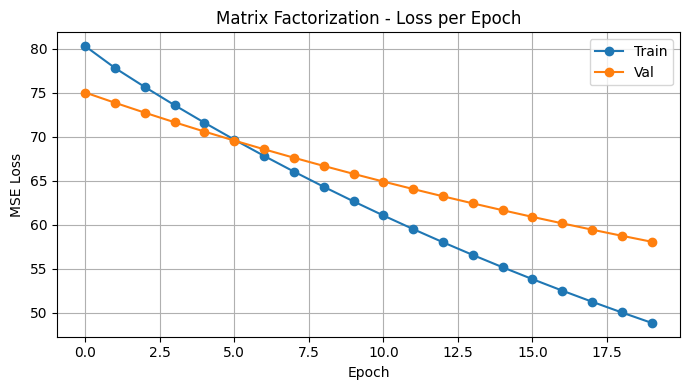

In [11]:
# 10. Plot Train/Val Loss Curves

# Path to training metrics log
LOG_PATH = "/mnt/cluster_storage/rec_sys_tutorial/epoch_metrics.json"

# Load and convert to DataFrame
with open(LOG_PATH, "r") as f:
    logs = json.load(f)

df = pd.DataFrame(logs)
df["train_loss"] = pd.to_numeric(df["train_loss"], errors="coerce")
df["val_loss"] = pd.to_numeric(df["val_loss"], errors="coerce")

# Plot
plt.figure(figsize=(7, 4))
plt.plot(df["epoch"], df["train_loss"], marker="o", label="Train")
plt.plot(df["epoch"], df["val_loss"], marker="o", label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Matrix Factorization - Loss per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 11 · Resume Training from Checkpoint  
Run `trainer.fit()` again to resume training from the most recent checkpoint. Since `TorchTrainer` was originally configured with `resume_from_checkpoint=True` and a persistent `storage_path`, Ray automatically restores the latest saved model state and continues training from the correct epoch.

This demonstrates Ray Train’s built-in support for fault tolerance and iterative experimentation, allowing training to pick up exactly where it left off without manual intervention.

In [12]:
# 11. Run trainer.fit() again to resume from last checkpoint

result = trainer.fit()

(TrainController pid=66838) A run snapshot was found in storage folder at: '/mnt/cluster_storage/rec_sys_tutorial/results/mf_ray_train'
(TrainController pid=66838) This snapshot contains a list of checkpoints reported via `ray.train.report` and will be loaded. This allows the latest checkpoint found in the snapshot to be accessible within your training function via `ray.train.get_checkpoint`.
(TrainController pid=66838) If you meant to start a brand new training job without any information about previous checkpoints found in this directory, please configure a new, unique `RunConfig(name)` or delete the existing folder at '/mnt/cluster_storage/rec_sys_tutorial/results/mf_ray_train'.
(TrainController pid=66838) [State Transition] INITIALIZING -> SCHEDULING.
(TrainController pid=66838) Attempting to start training worker group of size 8 with the following resources: [{'GPU': 1}] * 8
(TrainController pid=66838) Using blocking ray.get inside async actor. This blocks the event loop. Please u

### 12 · Inference: Recommend Top-N Items for a User  
To demonstrate inference, generate top-10 item recommendations for a randomly selected user.

First, reload the original `ratings.csv` and rebuild the user/item ID mappings used during training. Then, load the latest model checkpoint and restore the trained embedding weights. If you trained the model with DDP, strip the `'module.'` prefix from checkpoint keys.

Next, select a user, compute their embedding, and take the dot product against all item embeddings to produce predicted scores. Finally, extract the top-N items with the highest scores and print their IDs and associated scores.

In [14]:
# 12. Inference: Recommend Top-N Items for a User

# ---------------------------------------------
# Step 1: Reload original ratings CSV + mappings
# ---------------------------------------------
df = pd.read_csv("/mnt/cluster_storage/rec_sys_tutorial/raw/ratings.csv")

# Recompute ID mappings (same as during preprocessing)
unique_users = sorted(df["user_id"].unique())
unique_items = sorted(df["item_id"].unique())

user2idx = {uid: j for j, uid in enumerate(unique_users)}
item2idx = {iid: j for j, iid in enumerate(unique_items)}
idx2item = {v: k for k, v in item2idx.items()}

# ---------------------------------------------
# Step 2: Load model from checkpoint
# ---------------------------------------------
model = MatrixFactorizationModel(
    num_users=len(user2idx),
    num_items=len(item2idx),
    embedding_dim=train_config["embedding_dim"]
)

with result.checkpoint.as_directory() as ckpt_dir:
    state_dict = torch.load(os.path.join(ckpt_dir, "model.pt"), map_location="cpu")

    # Remove 'module.' prefix if using DDP-trained model
    if any(k.startswith("module.") for k in state_dict):
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)

model.eval()

# ---------------------------------------------
# Step 3: Select a user and generate recommendations
# ---------------------------------------------
# Choose a random user from the original dataset
original_user_id = df["user_id"].sample(1).iloc[0]
user_idx = user2idx[original_user_id]

print(f"Generating recommendations for user_id={original_user_id} (internal idx={user_idx})")

# Compute scores for all items for this user
with torch.no_grad():
    user_vector = model.user_embedding(torch.tensor([user_idx]))           # [1, D]
    item_vectors = model.item_embedding.weight                             # [num_items, D]
    scores = torch.matmul(user_vector, item_vectors.T).squeeze(0)          # [num_items]

    topk = torch.topk(scores, k=10)
    top_item_ids = [idx2item[j.item()] for j in topk.indices]
    top_scores = topk.values.tolist()

# ---------------------------------------------
# Step 4: Print Top-N Recommendations
# ---------------------------------------------
print("\nTop 10 Recommended Item IDs:")
for i, (item_id, score) in enumerate(zip(top_item_ids, top_scores), 1):
    print(f"{i:2d}. Item ID: {item_id} | Score: {score:.2f}")

Generating recommendations for user_id=332 (internal idx=331)

Top 10 Recommended Item IDs:
 1. Item ID: 1267 | Score: 19.36
 2. Item ID: 954 | Score: 17.42
 3. Item ID: 947 | Score: 17.13
 4. Item ID: 1625 | Score: 15.80
 5. Item ID: 1229 | Score: 15.33
 6. Item ID: 1373 | Score: 15.16
 7. Item ID: 338 | Score: 14.81
 8. Item ID: 729 | Score: 14.53
 9. Item ID: 1117 | Score: 14.26
10. Item ID: 1458 | Score: 14.20


### 13 · Join Top-N Item IDs with Movie Titles  
To make your recommendations more interpretable, join the top-10 recommended `item_id`s with movie titles from the original `u.item` metadata file.

Load only the relevant columns—`item_id` and `title`—from `u.item`, then merge them with the top-N predictions you computed in the previous step. The result is a user-friendly list of movie titles with associated predicted scores, rather than raw item IDs.

This small addition makes the model outputs easier to understand and more useful for downstream applications.

In [15]:
# 13. Join Top-N Item IDs with Movie Titles from u.item

item_metadata = pd.read_csv(
    "/mnt/cluster_storage/rec_sys_tutorial/ml-100k/u.item",
    sep="|",
    encoding="latin-1",
    header=None,
    usecols=[0, 1],  # Only item_id and title
    names=["item_id", "title"]
)

# Join with top-N items
top_items_df = pd.DataFrame({
    "item_id": top_item_ids,
    "score": top_scores
})

merged = top_items_df.merge(item_metadata, on="item_id", how="left")

print("\nTop 10 Recommended Movies:")
for j, row in merged.iterrows():
    print(f"{j+1:2d}. {row['title']} | Score: {row['score']:.2f}")


Top 10 Recommended Movies:
 1. Clockers (1995) | Score: 19.36
 2. Unzipped (1995) | Score: 17.42
 3. Big Blue, The (Grand bleu, Le) (1988) | Score: 17.13
 4. Nightwatch (1997) | Score: 15.80
 5. Poison Ivy II (1995) | Score: 15.33
 6. Good Morning (1971) | Score: 15.16
 7. Bean (1997) | Score: 14.81
 8. Nell (1994) | Score: 14.53
 9. Surviving Picasso (1996) | Score: 14.26
10. Damsel in Distress, A (1937) | Score: 14.20


### 14 · Cleanup Shared Storage  
Reclaim cluster disk space by deleting the entire tutorial output directory.  
Run this only when you’re **sure** you don’t need the checkpoints or metrics anymore.

In [16]:
# 14. Cleanup -- delete checkpoints and metrics from model training

TARGET_PATH = "/mnt/cluster_storage/rec_sys_tutorial"

if os.path.exists(TARGET_PATH):
    shutil.rmtree(TARGET_PATH)
    print(f"✅ Deleted everything under {TARGET_PATH}")
else:
    print(f"⚠️ Path does not exist: {TARGET_PATH}")

✅ Deleted everything under /mnt/cluster_storage/rec_sys_tutorial


(autoscaler +51m41s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


## 🎉 Wrapping Up & Next Steps

Awesome work making it to the end. In this tutorial, you used **Ray Train and Ray Data on Anyscale** to scale a full matrix factorization recommendation system, end-to-end, from a raw CSV to multi-GPU distributed training and personalized top-N item recommendations.

You should now feel confident:

* Using **Ray Data** to preprocess, encode, and shard large tabular datasets  
* Streaming data into PyTorch with `iter_torch_batches()` for efficient training  
* Scaling matrix factorization across multiple GPUs with **Ray Train’s `TorchTrainer`**  
* Saving and resuming training with distributed **Ray Checkpoints**  
* Running multi-node, fault-tolerant jobs without touching orchestration code  
* Performing post-training inference using Ray-restored model checkpoints and learned user/item embeddings

---

### 🚀 Where can you take this next?

Here are a few directions you can explore to extend or adapt this workload:

1. **Ranking Metrics & Evaluation**  
   * Add metrics like **Root Mean Squared Error (RMSE)**, **Normalized Discounted Cumulative Gain (NDCG)**, or **Hit@K** to evaluate recommendation quality.  
   * Filter out already-rated items during inference to measure novelty.

2. **Two-Tower and Deep Models**  
   * Replace dot product with a **two-tower neural model** or a **deep MLP**.  
   * Add side features (For example, timestamp, genre) into each tower for better personalization.

3. **Recommendation Personalization**  
   * Store and cache user embeddings after training.  
   * Run lightweight inference tasks to generate recommendations in real-time.

4. **Content-Based or Hybrid Models**  
   * Join movie metadata (genres, tags) and build a hybrid collaborative–content model.  
   * Embed titles or genres using pre-trained language models.

5. **Hyperparameter Optimization**  
   * Use **Ray Tune** to sweep embedding sizes, learning rates, or regularization.  
   * Track performance over epochs and checkpoint the best models automatically.

6. **Data Scaling**  
   * Switch from MovieLens 100K to 1M or 10M as Ray Data handles it seamlessly.  
   * Save and load from cloud object storage (S3, GCS) for real-world deployments.

7. **Production Inference**  
   * Wrap the recommendation system into a **Ray Serve** endpoint for serving top-N results.  
   * Build a simple demo that recommends movies to live users.

8. **End-to-End MLOps**  
   * Register the best model with MLflow or Weights & Biases.  
   * Package the training job as a Ray Job and schedule it with Anyscale.

9. **Multi-tenant recommendation systems**  
   * Extend this to support **multiple audiences** or contexts (For example, multi-country, A/B groups).  
   * Train and serve context-aware models in parallel using Ray.

This pattern gives you a solid foundation for scaling recommendation workloads across real datasets and real infrastructure—without rewriting your model or managing your cluster. Let Ray + Anyscale do the heavy lifting.